# **<center>Implement of word2vec</center>**

## 1 Inroduction the word2vec approach

If we apply one hot encoding, any two different words have a similarity of 0. And only two same words have a similarity of 1. For example, if we have two words 'statistics' and 'learning', we apply one hot encoding and calculate the similarity of them. What we could get are showing as below:
<center><img width="700" src = "https://drive.google.com/uc?export=view&id=18n1z5-NUKxnO9h4L5YPwfmVdfOZE-PFj"></center>

We could find that the similarity of two different words is 0. The matrix of one hot encoding is huge. It doesn't consider the similarity and the sequence of the word.

## 2 Preprocessing the data

We load the 'RedditNews.csv' into a 'DataFrame' named 'data'. Then we create a 'list' named 'news' to store all the news. We can find that there are totally 73608 news.

In [ ]:
# Access files from Google Drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import defaultdict
from scipy.special import expit
from sklearn.decomposition import PCA
import warnings

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/machine learning/RedditNews.csv', index_col = 0)
data.head(5)

,News
Date,
2016-07-01,A 117-year-old woman in Mexico City finally re...
2016-07-01,IMF chief backs Athens as permanent Olympic host
2016-07-01,"The president of France says if Brexit won, so..."
2016-07-01,British Man Who Must Give Police 24 Hours' Not...
2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [ ]:
news = data['News'].values.tolist()
print(news[2])
print(len(news))

The president of France says if Brexit won, so can Donald Trump
73608


In [ ]:
# We randomly select 2000 documents for easy calcualtion for the algorithm part
slice_news = random.sample(news, 2000)

We preprocess the data by using 'Tokenizer'. As the print shows, the third news has turned into a list of sequence of integers.

In [ ]:
# Set the Hyperparameters
max_number_words = 100000

# Preprocessing 
tokenizer = Tokenizer(num_words = max_number_words,
                      oov_token='UNK',
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                      lower=True)
# Create the word_index dictionary
tokenizer.fit_on_texts(slice_news)
# Transforming news into a list of lists of integers
news_processed = tokenizer.texts_to_sequences(slice_news)

In [ ]:
print(news_processed[2])

[3534, 2, 2244, 17, 1276, 1277, 2245, 2, 629, 3535]


We create a dictionary named 'word_to_index' and reverse it to get a new dictionary named 'index_to_word'. Then for each sentence of the processed news, we add '0' and 'max_number_words' at the start and the end of the sequence. According to the dictionary 'index_to_word', '0' indicates "$<\text{sos}>$" and 'max_number_words' indicates "$<\text{eos}>$".

In [ ]:
max_number_words = len(tokenizer.word_index)
word_to_index = {}
word_to_index['<sos>'] = 0

for word, index in tokenizer.word_index.items():
  if index < max_number_words:
    word_to_index[word] = index

word_to_index['<eos>'] = max_number_words

# Reverse the word_to_index into index_to_word
index_to_word = {index: word for word, index in word_to_index.items()}

sequences = []
for sequence in news_processed:
    sequences.append([0] + sequence + [max_number_words])

random.shuffle(sequence)

print(sequences[2])


[0, 3534, 2, 2244, 17, 1276, 1277, 2245, 2, 629, 3535, 8589]


To filter documnets with at least 6 words. We delete document with the length smaller than 8. Because we add "$<\text{sos}>$" and "$<\text{eos}>$" to the sequence. And we get the filtered sequences size as 1936.

In [ ]:
for sequence in sequences:
  if len(sequence) < 8:
    sequences.remove(sequence)

print(len(sequences))

1951


## 3 Preparing the training dataset for a binary classification problem from the processed corpus

### 3.1 Introducing the positive and negative batch associated with a true center word

We calculate the negative sampling distribution n according to the formula (3.1). And we set the return of this function as a dictionary of the word and its distribution.
We test the function by printing the negative sampling distribution.

In [ ]:
def negative_sampling(sequences, V):
  word_freq = defaultdict(int)
  
  for sequence in sequences:
    for word in sequence:
      if word < V:
        word_freq[word] += 1

  total_word = sum([freq**(3/4) for freq in word_freq.values()])
  negative_word_distribution = {word: freq**(3/4)/total_word for word, freq in word_freq.items()}
  #list_result = list(negative_word_distribution.values())
  return negative_word_distribution

In [ ]:
print(negative_sampling(sequences, max_number_words)[3])

0.009222298461759775


We define a new function named 'generate_negative_sampling'. It takes the distribution we define before and a positive smapling list as the input. In the function, we use random choice to select the fake word. For each sequence, we could get its positive sampling list (which generates true couples), then what we select as the fake center word should not be in the positive list.
We also test the function by initializing a positive list named 'pos_list' and use the function to generate the fake center word.

In [ ]:
def generate_negative_sampling(negative_word_distribution):
  fake_word = np.random.choice(list(negative_word_distribution.keys()), 
                               p = list(negative_word_distribution.values()))

  return fake_word

In [ ]:
fake_word = generate_negative_sampling(negative_sampling(sequences, max_number_words))
print(fake_word)

7400


We create a function named 'get_context_words'. We generate context word by selecting its left hand side and right hand side. We set the boundary by using function of max() and min().

In [ ]:
def get_context_words(position, sequence, contextsize):
  output_list = list()

  # For the left hand side
  for i in range(max(position-contextsize,0), position):
    output_list.append(sequence[i])
  
  # For the right hand side
  for i in range(position+1, min(position+contextsize, len(sequence)-1)+1):
    output_list.append(sequence[i])
  
  return output_list

We test the function with the following parameters:

position = 4

test_sequence = [0, 45, 64, 675, 56, 235, 76, 443, 654, 765, 10000]

test_contextsize = 3

And we get the same output list as the example shows.


In [ ]:
test_position = 4
test_sequence = [0, 45, 64, 675, 56, 235, 76, 443, 654, 765, 10000]
test_contextsize = 3
print(get_context_words(test_position, test_sequence, test_contextsize))

[45, 64, 675, 235, 76, 443]


### 3.2 A small Example

We create the fake corpus by deleting punctuations in the document and lower all letters.

In [ ]:
text1 = '...dire consequences for the UK economy, even as markets were rocked...'
text2 = '...High pay for bosses hurting economy says senior Bank of England...'
text3 = '...Mervyn King believes the world economy will soon face another crash...'

# Delete punctuation
text1 = re.sub(r'[^\w\s]','',text1)
text2 = re.sub(r'[^\w\s]','',text2)
text3 = re.sub(r'[^\w\s]','',text3)

# Turn into lower
text1 = text1.lower()
text2 = text2.lower()
text3 = text3.lower()

document1 = text1.split()
document2 = text2.split()
document3 = text3.split()


fake_corpus = [document1, document2, document3]

In [ ]:
print(fake_corpus)

[['dire', 'consequences', 'for', 'the', 'uk', 'economy', 'even', 'as', 'markets', 'were', 'rocked'], ['high', 'pay', 'for', 'bosses', 'hurting', 'economy', 'says', 'senior', 'bank', 'of', 'england'], ['mervyn', 'king', 'believes', 'the', 'world', 'economy', 'will', 'soon', 'face', 'another', 'crash']]


We iterate all the words in the fake corpus. If the word has been recorded in the dictionary, we continue our loop. If the word hasn't been recored in the dictionary, we record it with a new index. The index starts from 1.

In [ ]:
temp_index = 1

word2idx = {}

for text in fake_corpus:
  for word in text:
    if word in word2idx.keys():
      continue
    else:
      word2idx[word] = temp_index
      temp_index += 1

print(word2idx)

{'dire': 1, 'consequences': 2, 'for': 3, 'the': 4, 'uk': 5, 'economy': 6, 'even': 7, 'as': 8, 'markets': 9, 'were': 10, 'rocked': 11, 'high': 12, 'pay': 13, 'bosses': 14, 'hurting': 15, 'says': 16, 'senior': 17, 'bank': 18, 'of': 19, 'england': 20, 'mervyn': 21, 'king': 22, 'believes': 23, 'world': 24, 'will': 25, 'soon': 26, 'face': 27, 'another': 28, 'crash': 29}


We iterate each word in each document and append the corresponding index into a list. The corpus with a list of lists of integers is called 'processed_fake_corpus'.

In [ ]:
temp1 = []
temp2 = []
temp3 = []

for word in document1:
  temp1.append(word2idx[word])

for word in document2:
  temp2.append(word2idx[word])

for word in document3:
  temp3.append(word2idx[word])

processed_fake_corpus = [temp1, temp2, temp3]

print(processed_fake_corpus)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [12, 13, 3, 14, 15, 6, 16, 17, 18, 19, 20], [21, 22, 23, 4, 24, 6, 25, 26, 27, 28, 29]]


We use the function before to get the indices of the context words.

In [ ]:
q13_position = document2.index('economy')
q13_sequence = temp2
q13_contextsize = 3

q13_context_words_indices = get_context_words(q13_position, q13_sequence, q13_contextsize)
print(q13_context_words_indices)

[3, 14, 15, 16, 17, 18]


We first calculate the negative sampling distribution and then generate the index of fake word.

In [ ]:
q14_negative_sample_distribution = negative_sampling(processed_fake_corpus, 30)
q14_fake_word_idx = generate_negative_sampling(q14_negative_sample_distribution)
print(q14_fake_word_idx)

10


We reverse the 'word2idx' dictionary into 'idx2word' and get the fake center word as 'dire' in the fake corpus.

In [ ]:
idx2word = {index: word for word, index in word2idx.items()}
q15_fake_word = idx2word[q14_fake_word_idx]
print(q15_fake_word)

were


### 3.3 Creating the training dataset

We define for each corpus as the following:
<center><img width="280" src = "https://drive.google.com/uc?export=view&id=1oqDWHYihUegmXDNnLXfFzwPM1MeQT1SG"></center>
Then, we could get the sum of the total number of context words associated with each center word in each document as the following function:
<center><img width="160" src = "https://drive.google.com/uc?export=view&id=18zEl36AVdY_V5ggrDSQtcxWDcrs69hK6"></center>
Then, we could get the $N_T$ as followed:
<center><img width="300" src = "https://drive.google.com/uc?export=view&id=1nicHeAdy7sk6bHQsTiAdqJ9bVDK2DU3m"></center>



The number of fake couples is the same as the number of the true couples. Because it only changes the centre word from true centre word into fake centre word. Therefore, the number of fake couples is showing as followed:
<center><img width="300" src = "https://drive.google.com/uc?export=view&id=1YhF7pzKd7RUwF3uUKg9-eDqDWkQkwAQr"></center>

## 4 Learning the Word Vectors

### 4.1 The Forward Propagation

The structure and shape (in the backets) of $W_1$ and $W_2$ are showing as below:
<center><img width="600" src = "https://drive.google.com/uc?export=view&id=1wEjflXDU1yTR-MRouo8xlHk6BRkLk2by"></center>

We choose the $x$ row of $W_1$ and $o$ column of $W_2$. Then we calculate the probability of the $o$ position word works as the context word of the centre word $x$. While the output of sigmoid is between 0 and 1, the $p_o$ is the probability.
<center><img width="600" src = "https://drive.google.com/uc?export=view&id=17fv_VZRgb4EiqVK_hzFnIu-WGSTwnD52"></center>

### 4.1.1 The Forward Propagation for the positive batch associated with the center word $w^t_i$

Because we get the loss function as $J$ and the $t_n$ should be 1 for positive batch. Then we could get:
<center><img width="200" src = "https://drive.google.com/uc?export=view&id=1-y3P-9e437ALeAjia-UE7vRQqSq9aGD_"></center>

We have already know the formula for $p_o$. Here, we assume the centre word is $i_t$, number of context words is $K$ and they are represented as $k$. Therefore, the $J^{w^t_i}_+$ is:
<center><img width="300" src = "https://drive.google.com/uc?export=view&id=1NuPmystC25Qz171EhJsjbXuolfbcSeXb"></center>

### 4.1.2 The Forward Propagation for the negative batch associated with the center word $w^t_i$

Because we get the loss function as $J$ and the $t_n$ should be 0 for negative batch. Then we could get:
<center><img width="200" src = "https://drive.google.com/uc?export=view&id=1u5Q4eISZePHzP_Be1QHJTg4q7EBIsYBY"></center>

We have already know the formula for $p_o$. Here, we assume the fake centre word is $i_f$, number of context words is $K$ and they are represented as $k$. Therefore, the $J^{w^f_i}_-$ is:
<center><img width="300" src = "https://drive.google.com/uc?export=view&id=1n_5-H3vWbL090KTDDTpRbCEs2_YdtEy_"></center>


## 4.2 The Backward Propagation

### 4.2.1 Updating the parameters after the forward propagation associated with the positive batch

For true corpus, the $i_t$ row of $W_1$ and {$1,...,K$} columns of $W_2$ are involved in the computation of $p_c$.

The update equation of $W_1$ and $W_2$ after the forward propagation associated with positive batch are shown as below:
<center><img width="450" src = "https://drive.google.com/uc?export=view&id=1yTUe5xay4MO2Zb7_8KntykQLRyiARb34"></center>

### 4.2.2 Updating the parameters after the forward propagation associated with the negative batch

For fake corpus, the $i_f$ row of $W_1$ and {$1,...,K$} columns of $W_2$ are involved in the computation of $p_c$.

The update equation of $W_1$ and $W_2$ after the forward propagation associated with negative batch are shown as below:
<center><img width="450" src = "https://drive.google.com/uc?export=view&id=1vlG1KaOGFgguAxhr-7DUIIvK2bZgQ3Rb"></center>

We shuffle the sequences and only choose 2000 of them (this has been done before) for the test of the Word2Vec Algorithm.

We set the parameters at the top.

In [ ]:
# Define parameters
epoches = 50
learning_rate = 0.0025
V = max_number_words
D = 50
negative_sampling_distribution = negative_sampling(sequences, max_number_words)

# Gradient Descent Algorithm
W1 = np.random.random((V,D))
W2 = np.random.random((D,V))

losses = []

for epoch in range(epoches):
  loss = 0
  for sequence in sequences:
    position = 0
    for word in sequence:
      if index_to_word[word] != '<sos>' and index_to_word[word] != '<eos>':
        i_t = word
        i_t_position = position
        i_t_contextsize = 3
        position += 1
        i_t_context_words = get_context_words(i_t_position, sequence, i_t_contextsize)

        # Delete '<sos>' and '<eos>'
        if word_to_index['<sos>'] in i_t_context_words:
          i_t_context_words.remove(word_to_index['<sos>'])
        if word_to_index['<eos>'] in i_t_context_words:
          i_t_context_words.remove(word_to_index['<eos>'])

        # Generate fake center word
        while True:
          i_f = generate_negative_sampling(negative_sampling_distribution)
          if index_to_word[i_f] != '<sos>' and index_to_word[i_f] != '<eos>':
            break

        #print(i_t_context_words)

        W1_previous = W1
        W2_previous = W2
        J_loss_positive = 0
        sum_log_part = 0
        for i in range(len(i_t_context_words)):
          W1[[i_t],:] -= learning_rate*(expit(W1_previous[[i_t],:].dot(W2_previous[:,[i_t_context_words[i]]]))-1)*(W2_previous[:,[i_t_context_words[i]]].T)/len(i_t_context_words)
          W2[:,[i_t_context_words[i]]] -= learning_rate*(expit(W1_previous[[i_t],:].dot(W2_previous[:,[i_t_context_words[i]]]))-1)*(W1_previous[[i_t],:].T)/len(i_t_context_words)
          sum_log_part += np.log(expit(W1[[i_t],:].dot(W2[:,[i_t_context_words[i]]])))
        J_loss_positive = -1/len(i_t_context_words)*sum_log_part

        loss += J_loss_positive


        W1_previous = W1
        W2_previous = W2
        J_loss_negative = 0
        sum_log_part = 0
        for i in range(len(i_t_context_words)):
          W1[[i_f],:] -= learning_rate*(expit(W1_previous[[i_f],:].dot(W2_previous[:,[i_t_context_words[i]]])))*(W2_previous[:,[i_t_context_words[i]]].T)/len(i_t_context_words)
          W2[:,[i_t_context_words[i]]] -= learning_rate*(expit(W1_previous[[i_f],:].dot(W2_previous[:,[i_t_context_words[i]]])))*(W1_previous[[i_f],:].T)/len(i_t_context_words)
          sum_log_part += np.log(1- expit(W1[[i_f],:].dot(W2[:,[i_t_context_words[i]]])))
        J_loss_negative = -1/len(i_t_context_words)*sum_log_part

        loss += J_loss_negative

  
  losses.append(float(loss))
  if epoch in [9,19,29,39,49]:
    print(epoch+1)

10
20
30
40
50


We plot the list of losses. It shows that there is an significant decrease for the gradient.

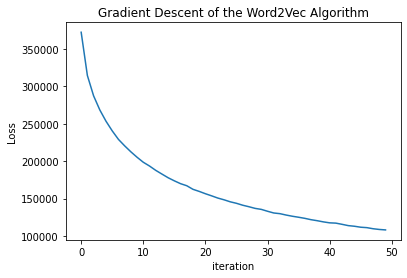

In [ ]:
plt.plot(losses)
plt.xlabel("iteration")
plt.ylabel("Loss")
plt.title("Gradient Descent of the Word2Vec Algorithm")
plt.show()

An embedding matrix is a list of all words and their corresponding embeddings. For each word $x$ in V, there are V dimension pairs of $W_1[x]$ and $W_2[i]$ to indicate the embedding matrix of $i$ that related to $x$. Therefore, the dimension of the embedding matrix is $V$.
We could get this embedding matrix by calculating the $W_1$ and $W_2$ to get a matrix of shape $V*V$. The column on the left indicating all the words while each row indicating the embedding vector of the word (with the size of $V$).


The idea here is that we assume the probabilities of each word is the embedding vector (with the size of $V$). However, there are some probabilities which are quite small, indicating that the word is not the contextword of the center word. 

So, the first step we do is to calcualte the embedding matrix by applying the formulation in Question 19 (the probability one). And then, we just use the $PCA$ to decrease the $V$ dimensions into $2$.

We show an example of word $to$ and its reduced embedding vector [24.54347934 -1.93969991].

Finally, we use scatter to plot the two dimensions. It shows a shape of 'Nike'.

In [ ]:
Q29_W1 = W1
Q29_W2 = W2
embedding_matrix = np.random.random((V,V))

for i in range(V):
  for j in range(V):
    embedding_matrix[i][j] = expit(Q29_W1[[i],:].dot(Q29_W2[:,[j]]))

pca = PCA(n_components = 2)
reduced_embedding_matrix = pca.fit_transform(embedding_matrix)

# Show the embedding vector of the third word
print(index_to_word[3])
print(reduced_embedding_matrix[3])

to
[24.54347934 -1.93969991]


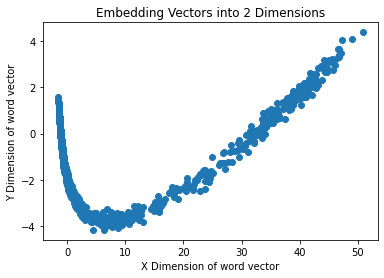

In [ ]:
plt.scatter(reduced_embedding_matrix[:,[0]], reduced_embedding_matrix[:,[1]])
plt.xlabel("X Dimension of word vector")
plt.ylabel("Y Dimension of word vector")
plt.title("Embedding Vectors into 2 Dimensions")
plt.show()


We use word_to_index function to find the word 'france', 'paris', 'england' and 'london'. Then we calcualte the difference between their embedding vector. From the result we could find that in the second dimension, two numbers are extremely close while in the first dimension, they are a small distance. This makes sense becuase we only use 2000 documents as the corpus. 

Then we try another pair $e_{China}$ - $e_{Beijing}$ and $e_{Korea}$ - $e_{Seoul}$. We could find that in both two dimensions, the numbers are very close. Therefore, we get the correct algorithm and embedding matrix.

In [ ]:
# Calcualte France - Paris and England - London

# France - Paris
print(reduced_embedding_matrix[word_to_index['france']]-reduced_embedding_matrix[word_to_index['paris']])

# England - London
print(reduced_embedding_matrix[word_to_index['england']]-reduced_embedding_matrix[word_to_index['london']])

[ 4.25693475 -0.84833848]
[ 8.92380335 -0.95580374]


In [ ]:
# Calcualte China - Beijing and Korea - Soul

# China - Beijing
print(reduced_embedding_matrix[word_to_index['china']]-reduced_embedding_matrix[word_to_index['beijing']])

# Korea - Seoul
print(reduced_embedding_matrix[word_to_index['korea']]-reduced_embedding_matrix[word_to_index['seoul']])

[42.39784114  2.2067881 ]
[43.13061523  2.14364273]
